Adapted from https://github.com/pyg-team/pytorch_geometric/blob/master/examples/upfd.py

In [431]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool, BatchNorm

In [432]:
train_dataset = UPFD("../data", "politifact", "profile", 'train')
val_dataset = UPFD("../data", "politifact", "profile", 'val')
test_dataset = UPFD("../data", "politifact", "profile", 'test')

Extracting ../data/politifact/raw/data.zip
Processing...
Done!


In [433]:
train_dataset[0]

Data(x=[72, 10], edge_index=[2, 71], y=[1])

In [438]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [439]:
class Net(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.3):
        super(Net, self).__init__()
        self.dropout = dropout

        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)

        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)

        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm(hidden_channels)

        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index)
        h = self.bn1(h)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)

        h = self.conv2(h, edge_index)
        h = self.bn2(h)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)

        h = self.conv3(h, edge_index)
        h = self.bn3(h)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)

        h = global_mean_pool(h, batch)
        out = self.classifier(h)
        return out

In [440]:
train_dataset.num_classes

2

In [451]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')  # Change to cpu if on Windows or non metal macs
model = Net(train_dataset.num_features, 128, train_dataset.num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [452]:
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_loader.dataset)

In [453]:
@torch.no_grad()
def test(loader):
    model.eval()

    total_correct = total_examples = 0
    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch).argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
        total_examples += data.num_graphs

    return total_correct / total_examples

In [454]:
train_accs = []
val_accs = []
test_accs = []
for epoch in range(1, 151):
    loss = train()
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    test_acc = test(test_loader)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.6976, Train: 0.6129, Val: 0.4194, Test: 0.5068
Epoch: 02, Loss: 0.6251, Train: 0.6935, Val: 0.5484, Test: 0.5792
Epoch: 03, Loss: 0.5888, Train: 0.7581, Val: 0.6129, Test: 0.7557
Epoch: 04, Loss: 0.5339, Train: 0.6774, Val: 0.6774, Test: 0.6516
Epoch: 05, Loss: 0.4918, Train: 0.6129, Val: 0.6129, Test: 0.6109
Epoch: 06, Loss: 0.4975, Train: 0.5484, Val: 0.5484, Test: 0.5837
Epoch: 07, Loss: 0.4639, Train: 0.5161, Val: 0.5484, Test: 0.5475
Epoch: 08, Loss: 0.4316, Train: 0.5000, Val: 0.5484, Test: 0.5339
Epoch: 09, Loss: 0.4162, Train: 0.4839, Val: 0.5484, Test: 0.5294
Epoch: 10, Loss: 0.4145, Train: 0.4839, Val: 0.5484, Test: 0.5339
Epoch: 11, Loss: 0.4034, Train: 0.4839, Val: 0.5484, Test: 0.5339
Epoch: 12, Loss: 0.3767, Train: 0.4839, Val: 0.5484, Test: 0.5339
Epoch: 13, Loss: 0.3511, Train: 0.4677, Val: 0.5484, Test: 0.5339
Epoch: 14, Loss: 0.3305, Train: 0.4677, Val: 0.5484, Test: 0.5294
Epoch: 15, Loss: 0.3273, Train: 0.4677, Val: 0.5806, Test: 0.5339
Epoch: 16,

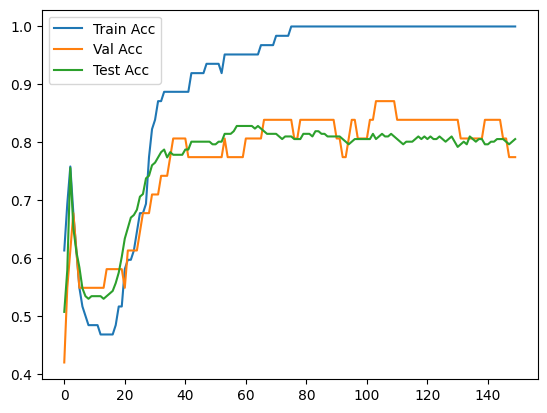

In [455]:
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.plot(test_accs, label='Test Acc')
plt.legend()
plt.show()

In [393]:
torch.save(model.state_dict(), "../models/gnn_pretrained.pth")